In [1]:
import music21 as m21
import pandas as pd
from abc_utils import *
from matplotlib import pyplot as plt
import numpy as np
from hmmlearn import hmm

RANDOM_STATE = 42

In [2]:
#  load in the dataset
# train, test = abc.load_harmonization_train_test()
train_set, train_lengths, _, val_set, val_lengths, _ = load_datasets()

In [3]:
def get_visualization_counts(output: pd.Series) -> pd.DataFrame:
    """
    Takes in the output column of a DataFrame and outputs a new DataFrame containing relevant information about the 
    songs in the output for use in visualization

    Parameters:
        output (pd.Series): the "output" column of the huge dataset

    Returns:
        vis_df (pd.DataFrame): the relevant visualization information
    """
    # initialzie output dataframe
    vis_df = pd.DataFrame()

    # helper to get the chords 
    def get_chord(text: str):
        chords = abc.abc_to_dataframe(text)['chord'].values.astype(list)
        return chords
        

    # helper to get the melody 
    def get_melody_notes(text: str):
        melody = abc.abc_to_dataframe(text)['melody'].values.astype(list)
        return melody
    
    # helper to get the keys
    def get_key(text: str):
        # get the score
        abc_score = m21.converter.parse(text, format='abc')
        
        # get the part
        part = abc_score.parts[0]

        # flatten the part and iterate through to find the key(s)
        key = None
        for item in part.flatten():
            # TODO: Ask: Are we sure there could be multiple keys? It slows things down a ton to look at the whole song when... hmm.
            if isinstance(item, m21.key.Key):
                key = item.__str__()
                break
                # TODO: Implement ordering of the keys to obtain frquencies of each key
        return key
    
    def get_length(melody: list):
        return len(melody)

    # use the functions to create the new dataframe
    vis_df['chords'] = output.apply(get_chord)
    vis_df['keys'] = output.apply(get_key)
    vis_df['melody'] = output.apply(get_melody_notes)
    vis_df['length'] = vis_df['melody'].apply(get_length)

    return vis_df

# use the function to get the dataframe of chords and notes
# Histogram of the roman numeral chords for all of the songs in the data set
# "confusion mmatrix" prob of transitioning from I to V


In [30]:
# test it
# vis_df = get_visualization_counts(train_set)
# vis_df.head(5)
train_lengths.min()

lengths    7
dtype: int64

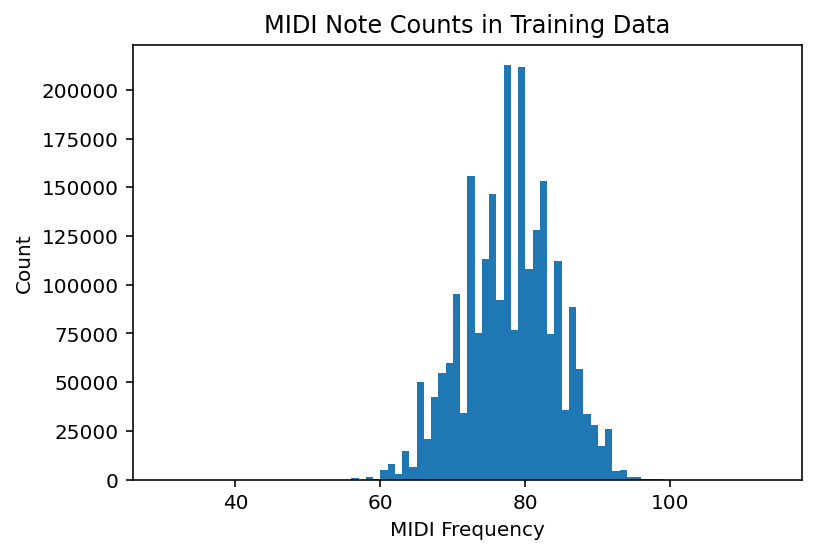

Number of Rests: 57791
Lowest Note MIDI Value: 30
Highest Note MIDI Value: 114


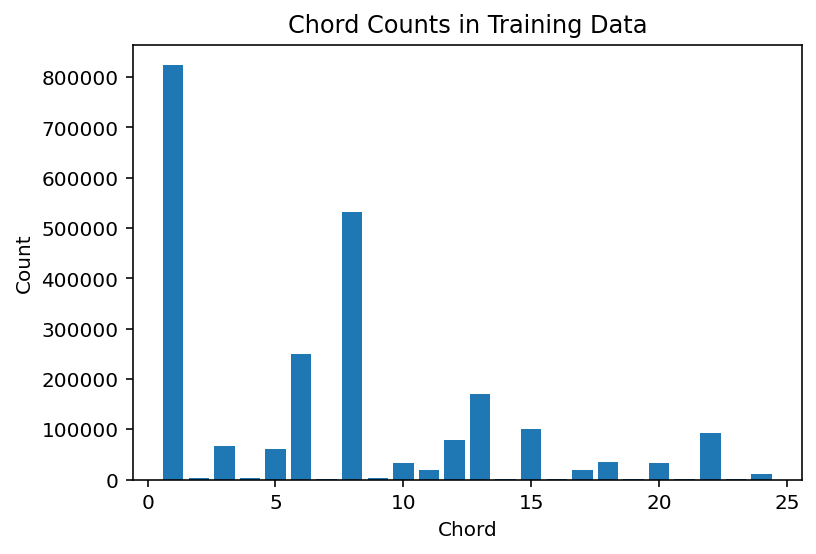

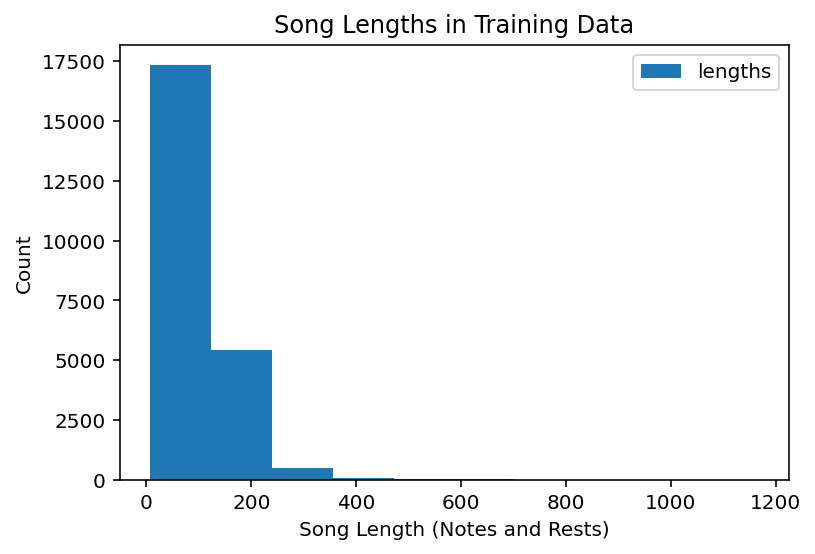

In [31]:
# plot the counts of the MIDI frequencies
# get all of the notes (count the rests and remove them)
all_notes = train_set['melody'].values
num_rests = np.sum(all_notes == 0)
all_notes = all_notes[all_notes != 0]

# get the high and low values and set the bins
low = np.min(all_notes)
high = np.max(all_notes)
bins = np.linspace(low, high, high - low + 1)

# plot
plt.hist(all_notes, bins=bins)
plt.title("MIDI Note Counts in Training Data")
plt.xlabel("MIDI Frequency")
plt.ylabel("Count")
plt.show()

# print descriptive statistics
print("Number of Rests:", num_rests)
print("Lowest Note MIDI Value:", low)
print("Highest Note MIDI Value:", high)

# create a bar graph of the starting keys
# TODO: Use the new key column to do this
# vis_df['keys'].value_counts().plot.bar()
# plt.xticks(rotation=45, ha="right")
# plt.title("Starting Key Counts in Training Data")
# plt.xlabel("Starting Key")
# plt.ylabel("Count")
# plt.show()

# create a histogram of the chords 
all_chords = train_set['chord'].values
all_chords = all_chords[all_chords != 0]
chord_list, counts = np.unique(all_chords, return_counts=True)
plt.bar(chord_list, counts)
plt.title("Chord Counts in Training Data")
plt.xlabel("Chord")
plt.ylabel("Count")
plt.show()

# plot the song lengths (number of notes and rests in the song)
train_lengths.plot(kind='hist')
plt.title("Song Lengths in Training Data")
plt.xlabel("Song Length (Notes and Rests)")
plt.ylabel("Count")
plt.show()

In [4]:
def load_song_subset(train_set, train_lengths, indices):
    """
    Create a subset of the train"""
    end_positions = np.cumsum(train_lengths)
    positions = np.insert(end_positions, 0, np.array([0]))
    songs = []
    for i in indices:
        song = train_set.iloc[positions[i] : positions[i+1]]
        songs.append(song)

    # return songs and lengths
    return pd.concat(songs), train_lengths.iloc[indices]

In [5]:
def fit_model(train_set: pd.DataFrame, train_lengths: pd.Series, num_chords: int=1, num_notes: int=0, subset: bool=False, indices=None, lam: int=None):
    """ 
    Takes in the train set and parameters for the state space and returns the trained model, along with all of the dictionaries needed to decode the model as a tuple.

    To train on a smaller subset of the full train set, use the subset argument and pass in the indices needed. Uses the load_song_subset function.
    """
    # check if we want to do a subset of the full train set; if so, perform it
    if subset:
        # check that indices are specified; raise and error if not
        if indices is None:
            raise ValueError("Indices must be specified if subset=True")
        train_set, _ = load_song_subset(train_set, train_lengths, indices)

    # obtain the states and observations from the songs
    true_states, true_observations = dataframe_to_states(train_set, num_chords, num_notes)
    
    # create the transition matrices for the model
    transition_matrix, emission_probs, unique_states, unique_obs, states_to_index, observation_to_index = states_to_transition(true_states, true_observations, lam)

    # now initialize the model and set the matrices for it
    model = hmm.CategoricalHMM(n_components=transition_matrix.shape[0], init_params='')
    model.transmat_ = transition_matrix.T
    model.emissionprob_ = emission_probs.T

    # starting_state = np.zeros(unique_states.shape[1])
    # starting_state_index = states_to_index[tuple(starting_state)]

    # start_probs = np.zeros(transition_matrix.shape[0])
    # start_probs[starting_state_index] = 1
    
    model.startprob_ = np.ones(transition_matrix.shape[0]) / transition_matrix.shape[0]

    # return the model,  the dictionaries
    return model, (unique_states, unique_obs, states_to_index, observation_to_index)

Processing states: 100%|██████████| 2414966/2414966 [02:22<00:00, 16981.98it/s]


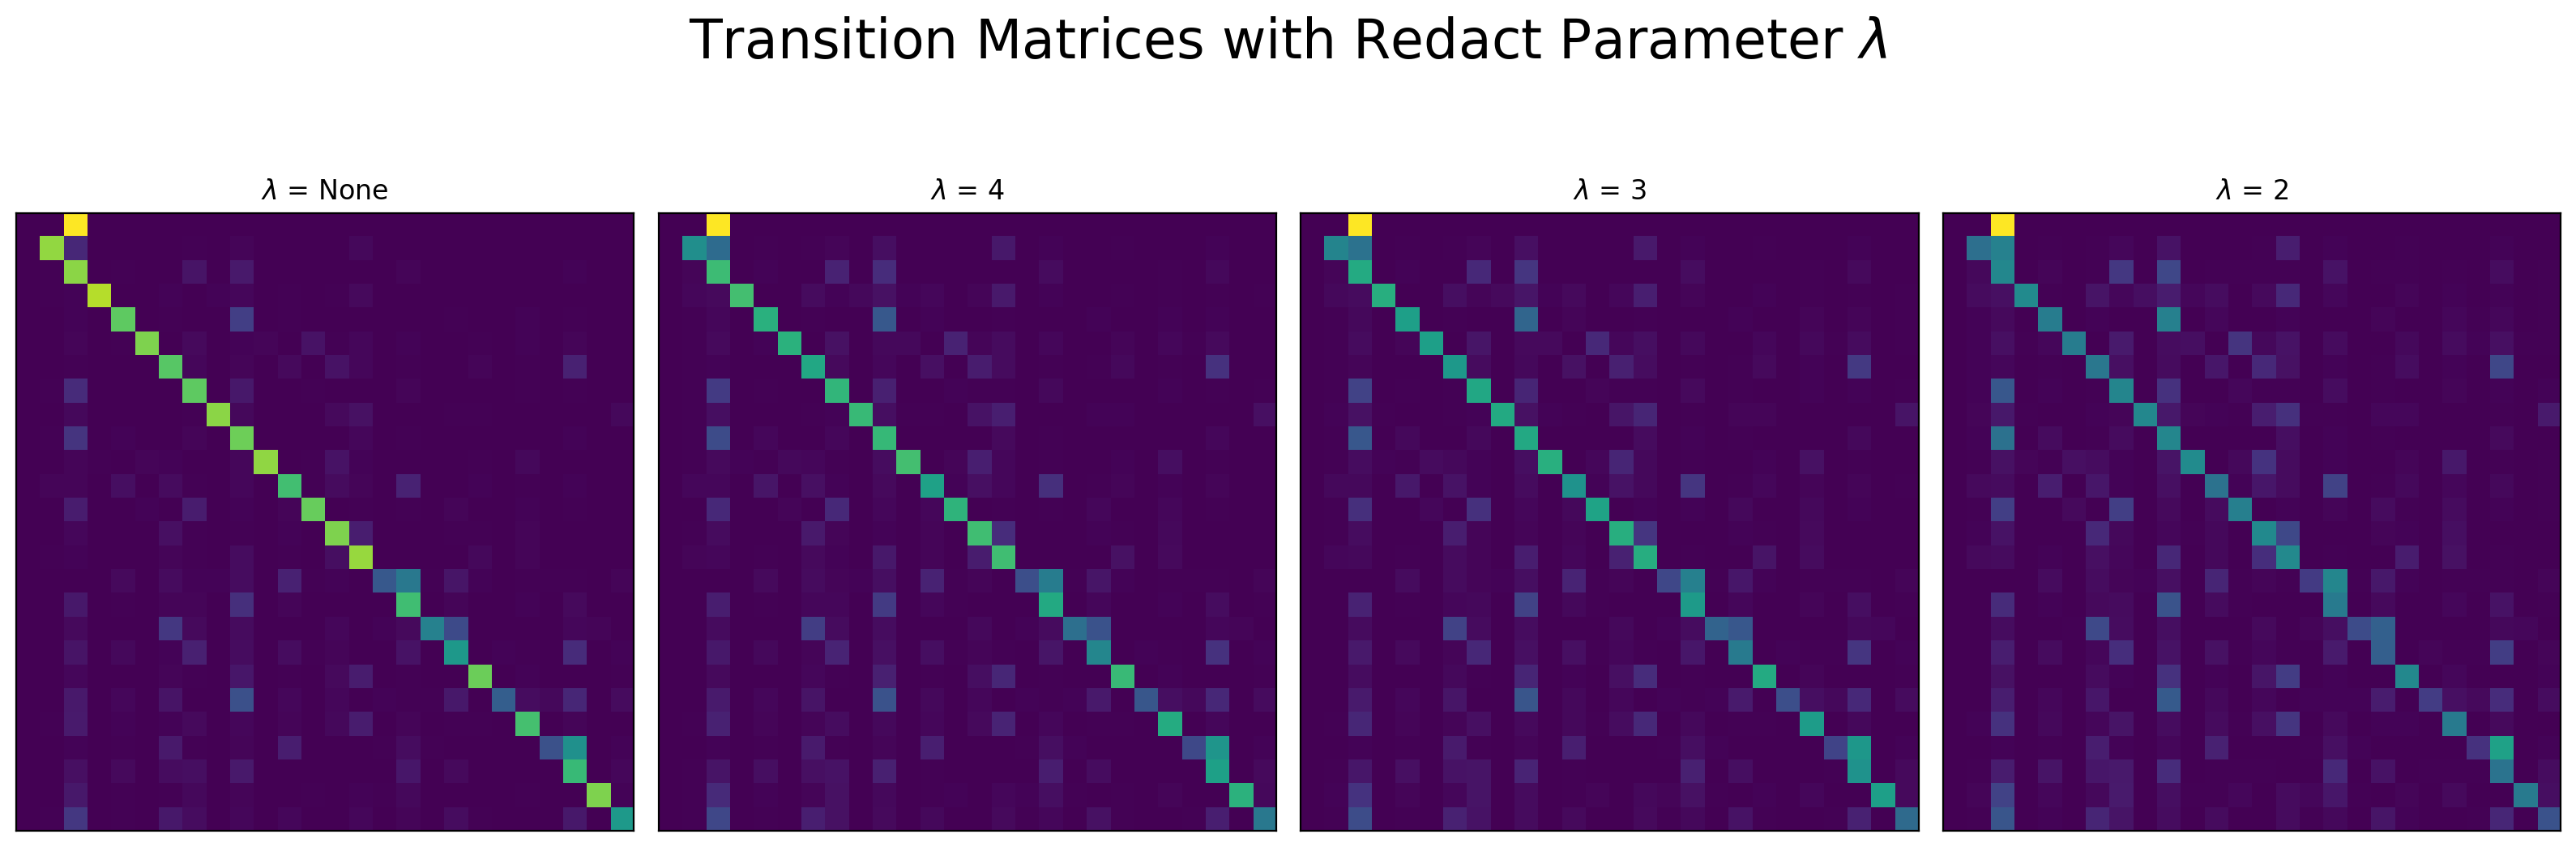

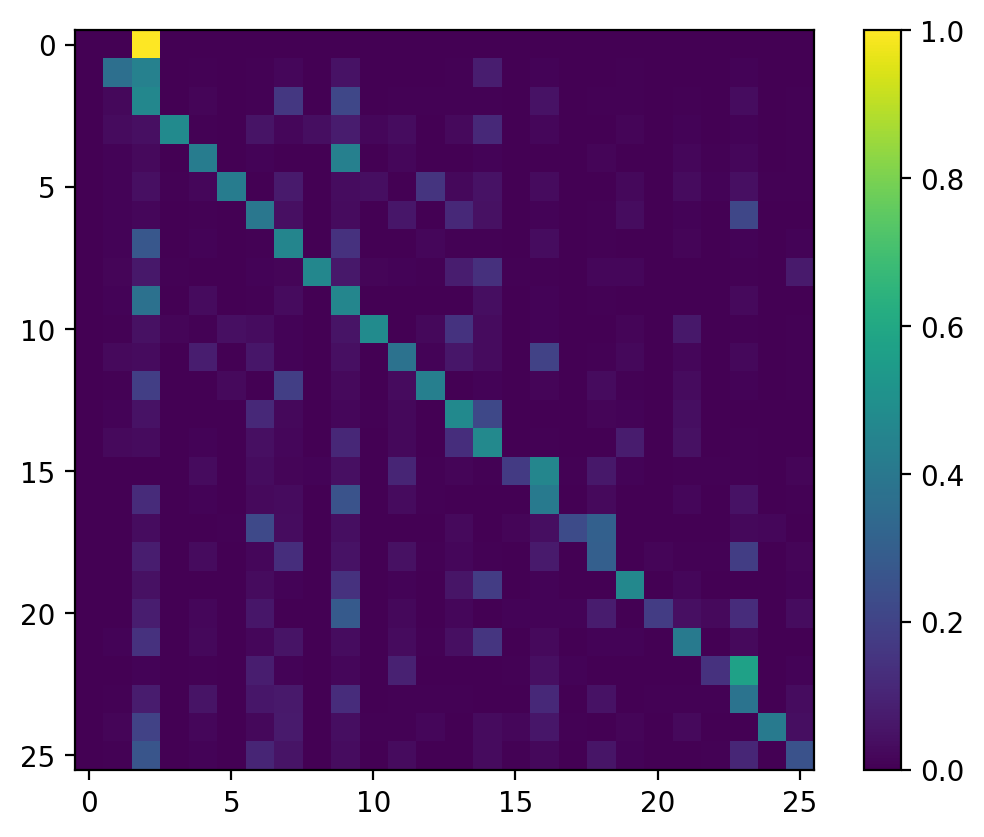

In [6]:
# create the confusion matrices for the redacted and non-redacted versions
num_chords = 1
num_notes = 0

fig, axes = plt.subplots(1, 4, figsize=(16, 6))
for i, lam in enumerate([None, 4, 3, 2]):
    # train the model
    model, all_dicts = fit_model(train_set, train_lengths, num_chords, num_notes, lam=lam)

    # get the transition matrix and plot it
    ax = axes[i]
    ax.imshow(model.transmat_, vmin=0, vmax=1)
    ax.set_title(r"$\lambda$ = "+str(lam))
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle(r"Transition Matrices with Redact Parameter $\lambda$", fontsize=24)
plt.tight_layout()
plt.show()
plt.imshow(model.transmat_)
plt.colorbar()
plt.show()